In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import scipy.io as io
import numpy as np
import pprint
import collections
import powerlaw

In [18]:
matrix = io.mmread('network/dense_start_fast.mtx')

G = nx.from_scipy_sparse_array(matrix)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print("First 10 edges:", list(G.edges())[:10])

Nodes: 1224, Edges: 2081
First 10 edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 18)]


Gather some insights into the description of the network.

In [9]:
def describe_network(G, name):
    # Basic statistics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Check if graph is directed
    is_directed = G.is_directed()

    # Check if graph is weighted
    is_weighted = any(data.get('weight', 1) != 1 for _, _, data in G.edges(data=True))

    # Density
    density = nx.density(G)

    print(f"\nNetwork Description for {name}:")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Directed: {is_directed}")
    print(f"Weighted: {is_weighted}")
    print(f"Network density: {density:.6f}\n")
    return num_nodes, num_edges, is_directed, is_weighted, density

    
num_nodes, num_edges, is_directed, is_weighted, density = describe_network(G, "Original Network")


Network Description for Original Network:
Number of nodes: 1224
Number of edges: 2081
Directed: False
Weighted: False
Network density: 0.002780



### Utility code.

In [10]:
#---TODO: add your functions that you'll use in the notebook repeatedly, if any
  
def degree_summary_and_distribution(G: nx.Graph):
    # Degree of a Node: The number of edges connected to a node.
    # Interpretation: A node's degree represents how many friends a person has on facebook.

    #  - the lowest number of friends
    #  - the highest number of friends
    #  - the average number of friends
    degrees = [d for _, d in G.degree()]
    min_degree = np.min(degrees)
    max_degree = np.max(degrees)
    avg_degree = np.mean(degrees)

    print(f"Min Degree: {min_degree}")
    print(f"Max Degree: {max_degree}")
    print(f"Average Degree: {avg_degree}")

    # count how many times each degree appears
    degree_count = collections.Counter(degrees)
    # sort the info and have separate lists
    degree_values, node_counts = zip(*sorted(degree_count.items()))

    total = sum(node_counts)
    node_counts = [y / total for y in node_counts]

    # plot as a dot graph
    plt.figure(figsize=(7, 5))
    plt.scatter(degree_values, node_counts, alpha=0.6, edgecolors='k')
    plt.title("Degree Distribution (Dot Plot)")
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    plt.grid(True)
    plt.show()


def connectivity(G: nx.Graph):
    is_connected = nx.is_connected(G)
    if not is_connected:
        # Connected Component: A group of nodes that are connected by paths.
        # The connected components can indicate if the network is one big cluster or composed of small ones.
        # Interpretation: Groups of friends isolated or interconnected.
        connected_components = list(nx.connected_components(G))
        num_connected_components = len(connected_components)
        largest_component_size = max(len(c) for c in connected_components)
        largest_cc = G.subgraph(max(connected_components, key=len))

    else:
        largest_component_size = len(G)
        largest_cc = G
        num_connected_components = 1

    print(f"The graph is connected: {is_connected}.")
    print(f"Number of Connected Components: {num_connected_components}.")
    print(f"Largest Component Size: {largest_component_size}.")

    # Diameter: the largest distance between any pair of nodes in the network.
    # Interpretation: the longest "friendship chain" connecting two users.
    diameter = nx.diameter(largest_cc) if nx.is_connected(largest_cc) else None
    
    print(f"Diameter: {diameter}")


def clustering_coefficient_and_degree_distribution_plot(G: nx.Graph):
    # Clustering Coefficient: Measures how tightly connected a node’s neighbors are (how likely it is for 2 nodes with a common neighbor to be linked).
    # Interpretation: How interconnected are on average the users. High clustering means high interaction between the friends of an user.
    avg_clustering = nx.average_clustering(G)
    
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Edge density: fraction of actual edges compared to the maximum possible edges.
    # Used to determine if the clustering coefficient is high or not.
    # NOTE: A low density means the network is sparse.
    edge_density = nx.density(G)

    print(f"Edge Density: {edge_density}")
    print(f"Clustering Coefficient is {"high" if avg_clustering > edge_density else "low"} compared to the edge density.")

    # plot clustering coefficient probability per degree
    degree_per_node = dict(G.degree())
    clustering_per_node = nx.clustering(G)

    # group clustering coefficients by degree
    clustering_by_degree = {}
    for node in G.nodes():
        k = degree_per_node[node]
        c = clustering_per_node[node]
        # if key already exists, make no change, else give a default
        clustering_by_degree.setdefault(k, [])
        clustering_by_degree[k].append(c)

    # compute average clustering coefficient per degree
    sorted_degrees = sorted(clustering_by_degree)
    avg_clustering_values_per_degree = [np.mean(clustering_by_degree[degree]) for degree in sorted_degrees]

    # Plot in log-log scale
    plt.figure(figsize=(6, 5))
    plt.scatter(sorted_degrees, avg_clustering_values_per_degree, alpha=0.6, edgecolors='k')
    plt.xlabel('Degree $k$')
    plt.ylabel('Clustering Coefficient $C(k)$')
    plt.title('Clustering Coefficient vs Degree')
    plt.grid(True)
    plt.show()
    
    return avg_clustering


def betweenness_centrality_distribution(G: nx.Graph):
    # Betweenness Centrality: measures how often a node appears on shortest paths between other nodes.
    # Interpretation: People with high betweeness are the connection between two separate groups. They transfer information between the groups.
    
    betweenness = list(nx.betweenness_centrality(G).values())

    avg_betweenness = np.mean(betweenness)
    max_betweenness = np.max(betweenness)

    print(f"Average Betweenness Centrality: {avg_betweenness}")
    print(f"Max Betweenness Centrality: {max_betweenness}")

    # Plot distribution
    plt.figure()
    plt.hist(betweenness, bins="auto", edgecolor="black", linewidth=0.2)
    plt.title("Betweenness Centrality Distribution")
    plt.xlabel("Betweenness Centrality")
    plt.ylabel("Frequency")
    # to diminish the big spikes in the plot 
    plt.yscale("log")
    plt.show()


def shortest_path_length_and_plot(largest_cc: nx.Graph):
    # Shortest path: minimum number of edges required to travel from one node to another.
    # Interpretation: The degree of separation between two users measured in friendships. 
    # NOTE: compare with no. nodes? 
    
    avg_shortest_path_length = nx.average_shortest_path_length(largest_cc)
    diameter = nx.diameter(largest_cc)

    print(f"Average Shortest Path Length: {avg_shortest_path_length}")
    print(f" - Diameter: {diameter}")

    # compute shortest paths between all node pairs
    lengths = dict(nx.all_pairs_shortest_path_length(largest_cc))

    # flatten distances into a list
    distance_counts = {}
    for source in lengths:
        for target in lengths[source]:
            if source != target:  # exclude self-loops
                d = lengths[source][target]
                distance_counts[d] = distance_counts.get(d, 0) + 1

    # normalize to get probability distribution
    total_pairs = sum(distance_counts.values())
    d_vals = sorted(distance_counts.keys())
    p_vals = [distance_counts[d] / total_pairs for d in d_vals]

    # plot probability distribution
    plt.figure(figsize=(7, 5))
    plt.plot(d_vals, p_vals, marker='o', alpha=0.6)
    plt.title("Shortest Path Length Distribution")
    plt.xlabel("Shortest Path Length $d$")
    plt.ylabel("Probability $p_d$")
    plt.axvline(x=np.average(d_vals, weights=p_vals), linestyle='--', color='gray', label='Average ⟨d⟩')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def compute_and_display_betweenness_centrality(G, graph_name):
    """
    Betweenness centrality measures how often a node lies on the shortest paths between others.
    High values indicate nodes that act as bridges in the network.
    """
    print(f"\n=== {graph_name} ===")

    betweenness = nx.betweenness_centrality(G)
    bc_sorted = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)

    print("Top 5 nodes by Betweenness Centrality:")
    for i in range(5):
        node, centrality = bc_sorted[i]
        print(f"Node {node}: {centrality:.4f}")

    return betweenness  

def compute_and_display_closeness_centrality(G, graph_name):
    """
    Closeness centrality shows how close a node is to all other nodes in the network.
    A high value means the node can quickly interact with others.
    """
    print(f"\n=== {graph_name} ===")

    closeness = nx.closeness_centrality(G)
    cc_sorted = sorted(closeness.items(), key=lambda item: item[1], reverse=True)

    print("Top 5 nodes by Closeness Centrality:")
    for i in range(5):
        node, centrality = cc_sorted[i]
        print(f"Node {node}: {centrality:.4f}")
    
    return closeness  

def compute_and_display_eigenvector_centrality(G, graph_name):
    """
    Eigenvector centrality reflects both the quantity and quality of a node’s connections.
    Nodes connected to other high-scoring nodes receive higher scores.
    """
    print(f"\n=== {graph_name} ===")
    
    try:
        eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
        ev_sorted = sorted(eigenvector.items(), key=lambda item: item[1], reverse=True)

        print("Top 5 nodes by Eigenvector Centrality:")
        for i in range(5):
            node, centrality = ev_sorted[i]
            print(f"Node {node}: {centrality:.4f}")

        return eigenvector  

    except nx.NetworkXError as e:
        print(f"⚠️ Could not compute eigenvector centrality for {graph_name}: {e}")
        return None

def plot_vs_degree(G, data, title, x_label, y_label):
    degree = nx.degree_centrality(G)

    x = [data[node] for node in G.nodes()]
    y = [degree[node] for node in G.nodes()]

    plt.figure(figsize=(7, 5))
    plt.scatter(x, y, alpha=0.6, edgecolors='k')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [13]:
def get_community_colors(G):
    communities = list(nx_comm.greedy_modularity_communities(G))
    color_map = {}
    for i, community in enumerate(communities):
        for node in community:
            color_map[node] = i
    return [color_map[node] for node in G.nodes()]

def plot_graph(G, name, layout_type="spring", figsize=(20, 20), opacity=0.8, wdth=0.3):
    colors = get_community_colors(G)

    layout_funcs = {
        "spring": nx.spring_layout,
        "kamada_kawai": nx.kamada_kawai_layout,
        "spectral": nx.spectral_layout,
        "shell": nx.shell_layout,
        "random": nx.random_layout,
        "fruchterman_reingold": nx.fruchterman_reingold_layout
    }
    
    pos = layout_funcs.get(layout_type, nx.spring_layout)(G)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.get_cmap("tab10"), node_size=30, alpha=0.9)
    nx.draw_networkx_edges(G, pos, edge_color="black", width=wdth, alpha=opacity)
    plt.title(f"{name} - {layout_type.capitalize()} Layout", fontsize=32)
    plt.axis('off')
    plt.show()

def plot_graph_all_layouts(G, name, figsize=(30, 20)):
    colors = get_community_colors(G)

    layout_funcs = {
        "spring": nx.spring_layout,
        "kamada_kawai": nx.kamada_kawai_layout,
        "spectral": nx.spectral_layout,
        "shell": nx.shell_layout,
        "random": nx.random_layout,
        "fruchterman_reingold": nx.fruchterman_reingold_layout
    }

    num_layouts = len(layout_funcs)
    cols = 3
    rows = (num_layouts + cols - 1) // cols

    plt.figure(figsize=figsize)
    
    for i, (layout_name, layout_func) in enumerate(layout_funcs.items(), 1):
        pos = layout_func(G)

        plt.subplot(rows, cols, i)
        nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.get_cmap("tab10"), node_size=20, alpha=0.9)
        nx.draw_networkx_edges(G, pos, edge_color="black", width=0.3, alpha=0.3)
        plt.title(f"{layout_name.capitalize()} Layout", fontsize=24)
        plt.axis('off')

    plt.suptitle(f"{name} - All Layouts", fontsize=36)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Steam Network (**name**)

#### Connectivity

#### Degree Distribution

Min Degree: 1
Max Degree: 54
Average Degree: 3.400326797385621


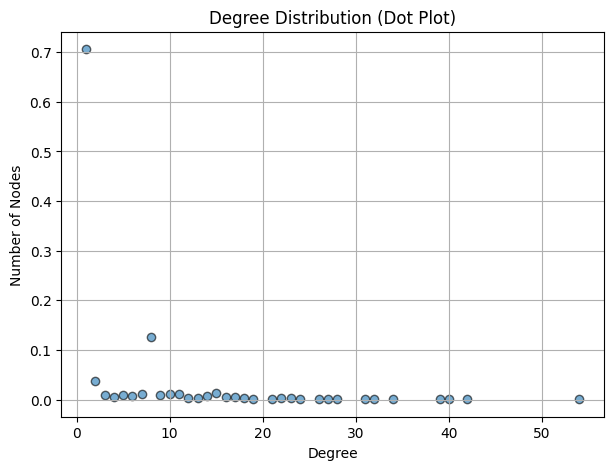

In [14]:
degree_summary_and_distribution(G)

#### Betweeness Centrality Distribution

Average Betweenness Centrality: 0.0039317219376461465
Max Betweenness Centrality: 0.2956441245420267


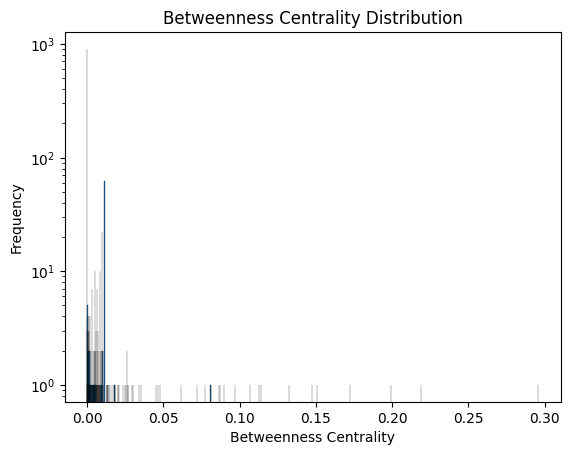

In [15]:
betweenness_centrality_distribution(G)

#### Clustering Coefficient

Average Clustering Coefficient: 0.06681918173095623
Edge Density: 0.002780316269325937
Clustering Coefficient is high compared to the edge density.


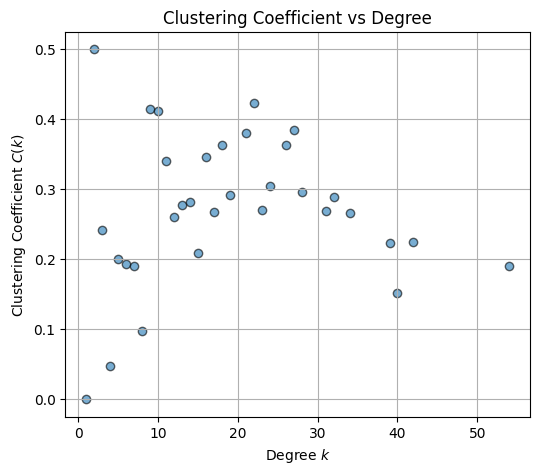

0.06681918173095623

In [16]:
clustering_coefficient_and_degree_distribution_plot(G)

#### Average Shortest Path

In [19]:
shortest_path_length_and_plot(G)

NetworkXError: Graph is not connected.

#### Visualization

#### Important Nodes

**Degree Centrality**

**Betweeness Centrality**

**Closeness Centrality**

**Egienvector Centrality**

### Network Type Analysis

### Communities